In [2]:
import pandas as pd
import numpy as np
import os
import sys
import cv2
import skimage.io
import random
import matplotlib.pyplot as plt

## Visualization of a prediction

Text(0.5, 1.0, 'Predicted mask (model output)')

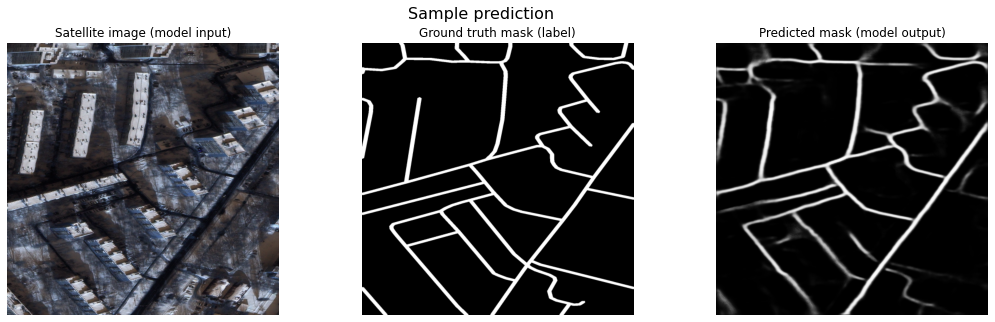

In [16]:
pred_dir = '/path/to/predictions'
sample='40'
im_path = os.path.join(pred_dir, '{}_original.png'.format(sample))
pred_path = os.path.join(pred_dir, '{}_pred.png'.format(sample))
gt_path = os.path.join(pred_dir, '{}_ground-truth.png'.format(sample))

# plot
fig, ((ax0,ax1,ax2)) = plt.subplots(1,3, figsize=(18,5))

# image
ax0.imshow(cv2.imread(im_path, cv2.IMREAD_UNCHANGED))
ax0.axis('off')
ax0.set_title('Satellite image (model input)')

# grount truth
ax1.imshow(cv2.imread(gt_path, 1))
ax1.axis('off')
ax1.set_title('Ground truth mask (label)')

fig.suptitle('Sample prediction', fontsize=16)

# prediction
ax2.imshow(cv2.imread(pred_path, 1))
ax2.axis('off')
ax2.set_title('Predicted mask (model output)')


## Post-processing of predicted mask (vizualization of steps)

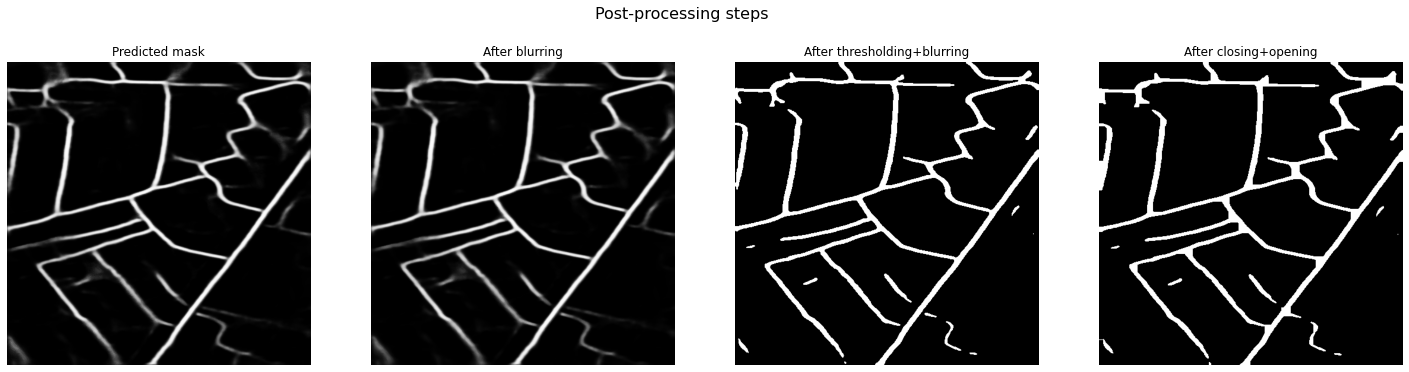

In [9]:
import skimage.morphology
from skimage.morphology import skeletonize, remove_small_objects, remove_small_holes, medial_axis
pred = cv2.imread(pred_path,1)
kernel_close = 12
kernel_open = 3
kernel_blur = 3
kernel_close = np.ones((kernel_close,kernel_close), np.uint8)
kernel_open = np.ones((kernel_open, kernel_open), np.uint8)
glob_thresh=80
fig, ((ax0, ax1, ax2, ax3)) = plt.subplots(1,4, figsize=(25,6))

blur = cv2.medianBlur(pred, kernel_blur)


# global thresh
glob_thresh_arr = cv2.threshold(blur, glob_thresh, 255, cv2.THRESH_BINARY)[1]
glob_thresh_arr_smooth = cv2.medianBlur(glob_thresh_arr, kernel_blur)


mask_thresh = glob_thresh_arr_smooth
closing = cv2.morphologyEx(mask_thresh, cv2.MORPH_CLOSE, kernel_close)

opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel_open)

#remove holes etc here


#skeletonize
#https://scikit-image.org/docs/dev/auto_examples/edges/plot_skeleton.html#sphx-glr-auto-examples-edges-plot-skeleton-py
#or medial int

medial_int = medial_axis(opening[:,:,-1]).astype(np.uint8)

ax0.imshow(pred)
ax0.axis('off')
ax0.set_title('Predicted mask')


ax1.imshow(blur)
ax1.axis('off')
ax1.set_title('After blurring')


ax2.imshow(glob_thresh_arr_smooth)
ax2.axis('off')
ax2.set_title('After thresholding+blurring')

ax3.imshow(closing)
ax3.axis('off')
ax3.set_title('After closing+opening')

fig.suptitle('Post-processing steps', fontsize=16)

plt.show()


## Image2graph
We will now represent the post-processed predicted masks as graphs. See below for the operations required. 

Text(0.5, 1.0, 'Topological skeleton (medial axis)')

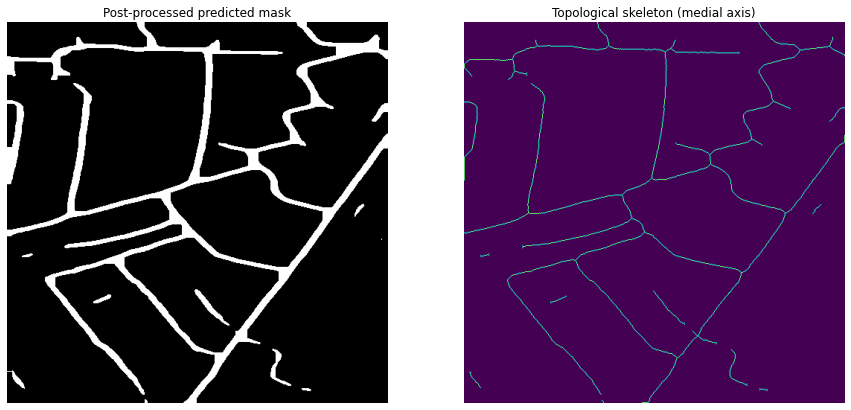

In [10]:
fig, ((ax0, ax1)) = plt.subplots(1,2, figsize=(15,7))

ax0.imshow(closing)
ax0.axis('off')
ax0.set_title('Post-processed predicted mask')


ax1.imshow(medial_int)
ax1.axis('off')
ax1.set_title('Topological skeleton (medial axis)')

## Graph representation from skeleton

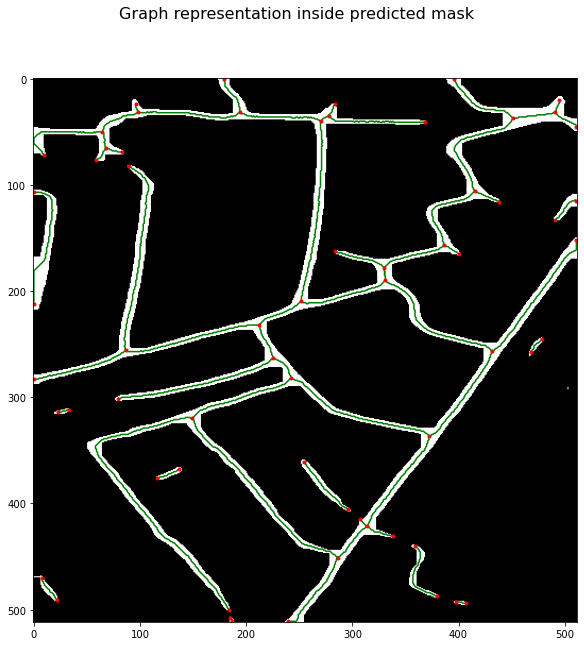

In [15]:
import sknw
import networkx as nx

graph = sknw.build_sknw(medial_int)
fig = plt.figure(figsize = (10,10))
plt.imshow(closing)
for (s,e) in graph.edges():
    ps = graph[s][e]['pts']
    plt.plot(ps[:,1], ps[:,0], 'green')
    
# draw node by o
nodes = graph.nodes()
ps = np.array([nodes[i]['o'] for i in nodes])
plt.plot(ps[:,1], ps[:,0], 'r.')
fig.suptitle('Graph representation inside predicted mask', fontsize=16)
plt.show()

## Optimal routing with Dijkstra algo
Finally, we can calculate optimal paths in the graph representations of the predicted masks.

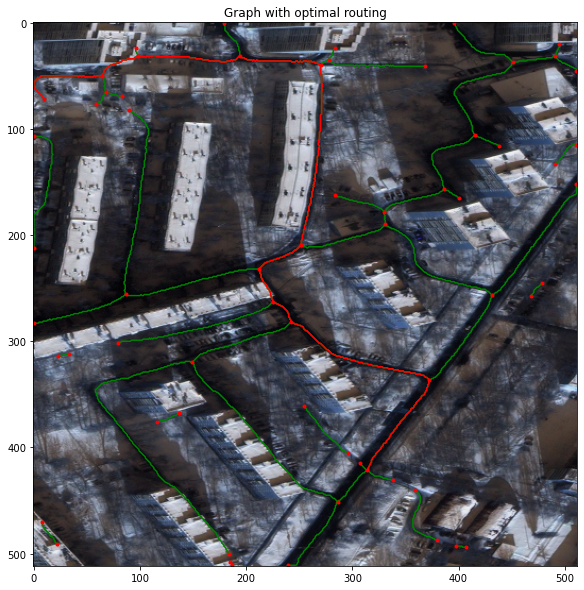

882.7371567773475

In [85]:
import sknw
import networkx as nx

graph = sknw.build_sknw(medial_int)
plt.figure(figsize = (10,10))
plt.imshow(cv2.imread(im_path, cv2.IMREAD_UNCHANGED))
for (s,e) in graph.edges():
    ps = graph[s][e]['pts']
    plt.plot(ps[:,1], ps[:,0], 'green')
    
# draw node by o
nodes = graph.nodes()
ps = np.array([nodes[i]['o'] for i in nodes])
plt.plot(ps[:,1], ps[:,0], 'r.')


# Optimal routing based on length
length, path = nx.single_source_dijkstra(graph, 16, 50, weight='weight')
path_edges = list(zip(path,path[1:]))
for (s,e) in path_edges:
    ps = graph[s][e]['pts']
    plt.plot(ps[:,1], ps[:,0], 'red')

plt.title('Graph with optimal routing')
plt.show()

In [70]:
length

882.7371567773475